# FL with compression

In this notebook, we will show how to use lossy compressor in FL to compress the model parameters and reduce the communication cost.

## Install compressors

To install the compressors, fist make sure that you have installed necessary packages for the compressors by running the following command in the `APPFL` directory.

```bash
pip install -e . # if you installed using source code
```

or 

```bash
pip install appfl # if you installed directly using pypi
```

Then, you can easily install the lossy compressors by running the following command anywhere. It will download all the source code for compressors under `APPFL/.compressor`.

```bash
appfl-install-compressor
```

💡 `appfl.compressor` supports four compressors: [SZ2](https://github.com/szcompressor/SZ), [SZ3](https://github.com/szcompressor/SZ3), [ZFP](https://pypi.org/project/zfpy/), and [SZX](https://github.com/szcompressor/SZx). However, as SZx needs particular permission to access, so we have to omit its installation here. If you want to try with SZx, please contact its authors.

## Load server and client configurations

Following the same steps in the [serial FL example](serial_fl.ipynb), we load and modify the configurations for server and five clients.

In [1]:
num_clients = 5

import copy
from omegaconf import OmegaConf

server_config_file = "../../examples/resources/configs/mnist/server_fedavg.yaml"
server_config = OmegaConf.load(server_config_file)
server_config.client_configs.train_configs.loss_fn_path = '../../examples/resources/loss/celoss.py'
server_config.client_configs.train_configs.metric_path = '../../examples/resources/metric/acc.py'
server_config.client_configs.model_configs.model_path = '../../examples/resources/model/cnn.py'
server_config.server_configs.num_global_epochs = 10
server_config.server_configs.scheduler_kwargs.num_clients = num_clients

client_config_file = "../../examples/resources/configs/mnist/client_1.yaml"
client_config = OmegaConf.load(client_config_file)
client_configs = [
    copy.deepcopy(client_config) for _ in range(num_clients)
]
for i in range(num_clients):
    client_configs[i].train_configs.logging_id = f'Client_{i+1}'
    client_configs[i].data_configs.dataset_path = '../../examples/resources/dataset/mnist_dataset.py'
    client_configs[i].data_configs.dataset_kwargs.num_clients = num_clients
    client_configs[i].data_configs.dataset_kwargs.client_id = i
    client_configs[i].data_configs.dataset_kwargs.visualization = True if i == 0 else False

print(OmegaConf.to_yaml(server_config))

client_configs:
  train_configs:
    trainer: VanillaTrainer
    mode: step
    num_local_steps: 100
    optim: Adam
    optim_args:
      lr: 0.001
    loss_fn_path: ../../examples/resources/loss/celoss.py
    loss_fn_name: CELoss
    do_validation: true
    do_pre_validation: true
    metric_path: ../../examples/resources/metric/acc.py
    metric_name: accuracy
    use_dp: false
    epsilon: 1
    clip_grad: false
    clip_value: 1
    clip_norm: 1
    train_batch_size: 64
    val_batch_size: 64
    train_data_shuffle: true
    val_data_shuffle: false
  model_configs:
    model_path: ../../examples/resources/model/cnn.py
    model_name: CNN
    model_kwargs:
      num_channel: 1
      num_classes: 10
      num_pixel: 28
  comm_configs:
    compressor_configs:
      enable_compression: true
      lossy_compressor: SZ2Compressor
      lossless_compressor: blosc
      error_bounding_mode: REL
      error_bound: 0.001
      param_cutoff: 1024
server_configs:
  scheduler: SyncScheduler
  

## Enable compression

To enable compression, we just need to set `server_config.client_configs.comm_configs.compressor_configs.enable_compression` to True.

💡 You may notices that both `server_config.server_configs` and `server_config.client_configs` have a `comm_configs` fields. Actually, when creating the server agent, its communication configurations will be the merging of `server_config.server_configs.comm_configs` and `server_config.client_configs.comm_configs`. However, `server_config.client_configs.comm_configs` will also be shared with clients, while `server_config.server_configs.comm_configs` will not. As we want the clients to be aware of the compressor configurations, we put `compressor_configs` under `server_config.client_configs.comm_configs` to share with the clients during the FL experiment.

## Create the agents and start the experiment

[Zilinghans-MBP.attlocal.net:97722] shmem: mmap: an error occurred while determining whether or not /var/folders/b_/gwq73k4j7z53_f2qmdwcl22w0000gp/T//ompi.Zilinghans-MBP.502/jf.0/3678076928/sm_segment.Zilinghans-MBP.502.db3b0000.0 could be created.
[2024-08-24 23:11:25,123 INFO server]: Logging to ./output/result_Server_2024-08-24-23:11:25.txt
[2024-08-24 23:11:25,123 INFO server]: Setting seed value to 42
[2024-08-24 23:11:25,130 INFO Client_1]: Logging to ./output/result_Client_1_2024-08-24-23:11:25.txt
[2024-08-24 23:11:32,910 INFO Client_2]: Logging to ./output/result_Client_2_2024-08-24-23:11:32.txt
[2024-08-24 23:11:40,075 INFO Client_3]: Logging to ./output/result_Client_3_2024-08-24-23:11:40.txt
[2024-08-24 23:11:47,067 INFO Client_4]: Logging to ./output/result_Client_4_2024-08-24-23:11:47.txt
[2024-08-24 23:11:54,078 INFO Client_5]: Logging to ./output/result_Client_5_2024-08-24-23:11:54.txt
[2024-08-24 23:12:01,073 INFO Client_1]:      Round   Pre Val?       Time Train Loss 

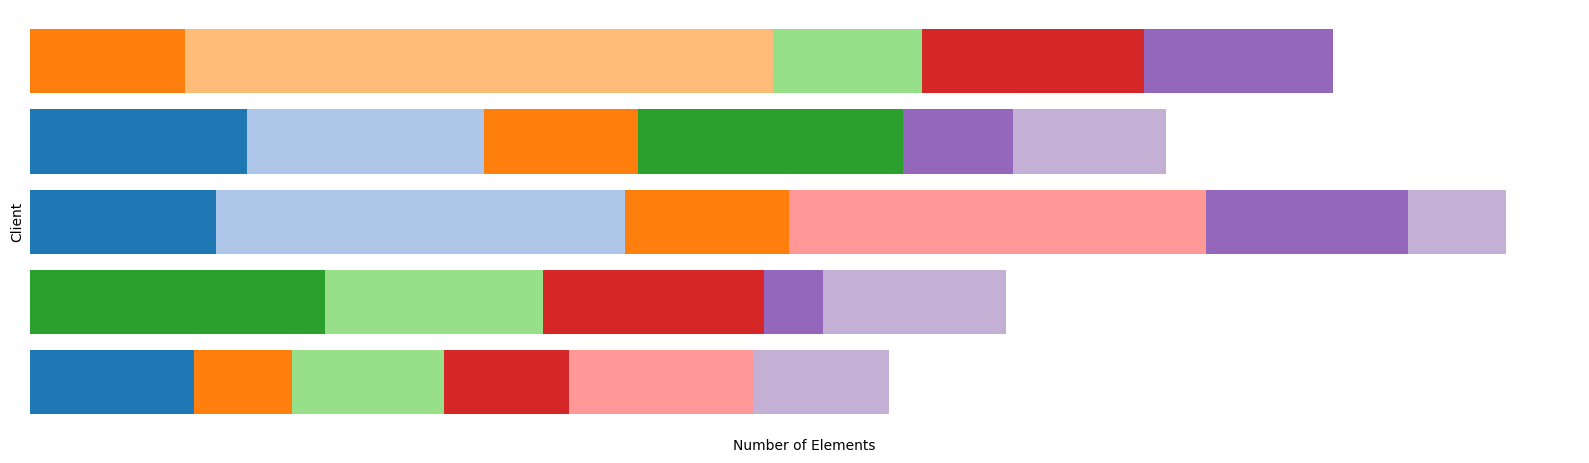

In [2]:
from appfl.agent import ServerAgent, ClientAgent
# Create server and client agents
server_agent = ServerAgent(server_agent_config=server_config)
client_agents =[
    ClientAgent(client_agent_config=client_configs[i]) for i in range(num_clients)
]

# Get additional client configurations from the server
client_config_from_server = server_agent.get_client_configs()
for client_agent in client_agents:
    client_agent.load_config(client_config_from_server)

# Load initial global model from the server
init_global_model = server_agent.get_parameters(serial_run=True)
for client_agent in client_agents:
    client_agent.load_parameters(init_global_model)

# [Optional] Set number of local data to the server
for i in range(num_clients):
    sample_size = client_agents[i].get_sample_size()
    server_agent.set_sample_size(
        client_id=client_agents[i].get_id(), 
        sample_size=sample_size
    )

while not server_agent.training_finished():
    new_global_models = []
    for client_agent in client_agents:
        # Client local training
        client_agent.train()
        local_model = client_agent.get_parameters()
        # "Send" local model to server and get a Future object for the new global model
        # The Future object will be resolved when the server receives local models from all clients
        new_global_model_future = server_agent.global_update(
            client_id=client_agent.get_id(), 
            local_model=local_model,
            blocking=False,
        )
        new_global_models.append(new_global_model_future)
    # Load the new global model from the server
    for client_agent, new_global_model_future in zip(client_agents, new_global_models):
        client_agent.load_parameters(new_global_model_future.result())